### Bitcoin Pricing Analysis

This notebook will run through EDA, feature engineering and pricing analysis on Bitcoin. We will look at feature engineering and different forecast time scales to see if there is any signal there. This might be in vain due to the volatility of Bitcoin!

Based on Bitstamp exchange Bitcoin pricing data set from Kaggle:

Accessed: 2020/11/01

https://www.kaggle.com/mczielinski/bitcoin-historical-data

In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from datetime import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# data
from sklearn.compose import ColumnTransformer, make_column_transformer

# Classifiers
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost.core import CatBoostClassifier

# other
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    TimeSeriesSplit,
    KFold
)

from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import VotingClassifier, StackingClassifier

#Tsfresh
from tsfresh.examples import load_robot_execution_failures
from tsfresh.transformers import RelevantFeatureAugmenter
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

# Helper funcs:
from utils import PurgedGroupTimeSeriesSplit, plot_cv_indices

plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (15, 8)

# For reloading helper files on change:
%load_ext autoreload
%autoreload 2


In [2]:
data = pd.read_csv(
    "data/bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv",
    parse_dates=["Timestamp"],
    date_parser=lambda x: pd.to_datetime(x, unit="s"),
    index_col="Timestamp",
)
data.columns = data.columns.str.lower().str.replace("[()]", "", regex=True)
data.index.rename("timestamp", inplace=True)
data.shape

(4572257, 7)

Fair bit of data! It is stored by minute frequency but thinking we'll aggregate to a more manageable prediction window (maybe even more stable).

In [3]:
data.head()

,open,high,low,close,volume_btc,volume_currency,weighted_price
timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.isna().sum()

open               1241716
high               1241716
low                1241716
close              1241716
volume_btc         1241716
volume_currency    1241716
weighted_price     1241716
dtype: int64

Lots of NA's! Let's see if it's just early pricing data. Look at how many data points are NA each month, each hour:

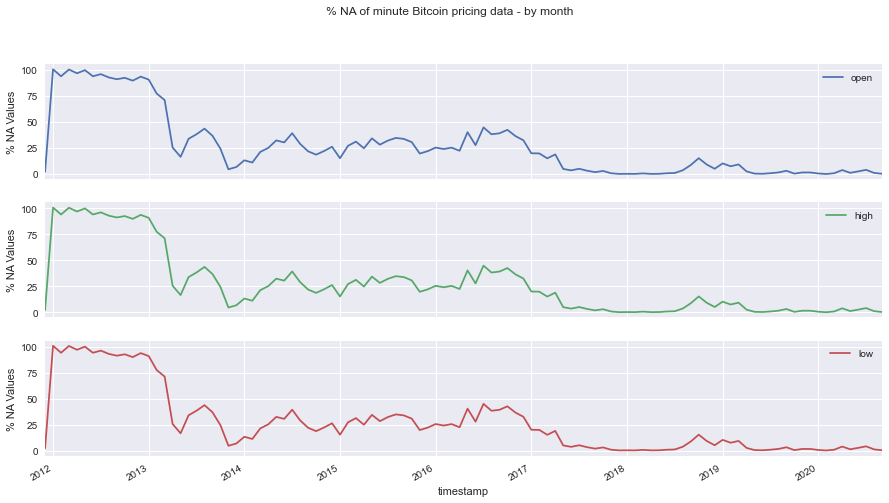

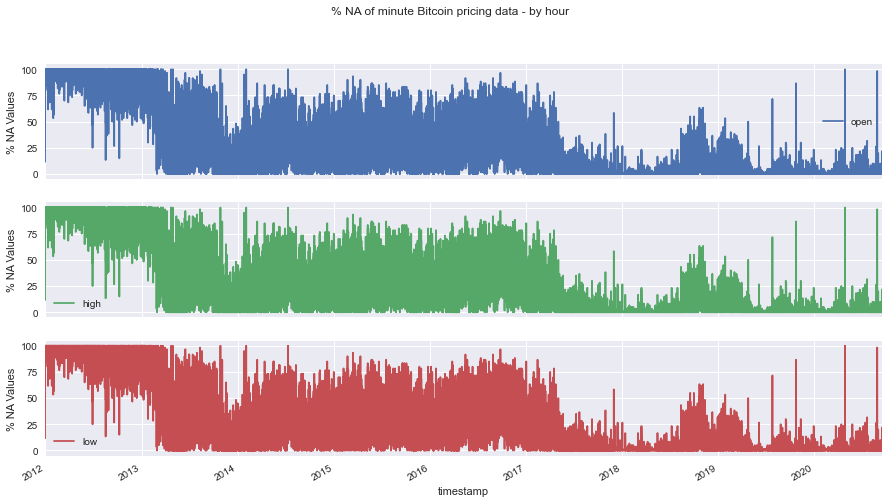

In [5]:
# For each month
(
    data.isna()
    .groupby(pd.Grouper(freq="M"))
    .sum()
    .apply(
        lambda x: 100 * x / (30.4 * 24 * 60)
    )[  # Calculate fraction of monthly values are NA
        ["open", "high", "low"]
    ]
    .plot(
        kind="line",
        subplots=True,
        title="% NA of minute Bitcoin pricing data - by month",
        ylabel="% NA Values",
    )
)

(
    data.isna()
    .groupby(pd.Grouper(freq="H"))
    .sum()
    .apply(
        lambda x: 100 * x / (60)
    )[  # Calculate fraction of hours reading values are NA
        ["open", "high", "low"]
    ]
    .plot(
        kind="line",
        subplots=True,
        title="% NA of minute Bitcoin pricing data - by hour",
        ylabel="% NA Values",
    )
);

Ok - a fair bit of NA's to deal with. From the dataset page, this is noted as "no trades having occured". Potentially forward filling these should work then.

We should probably throw out data before ~ 2014. The Bitstamp exchange was founded in 2011 and potentially just didn't have the trade volumes until 2014. 

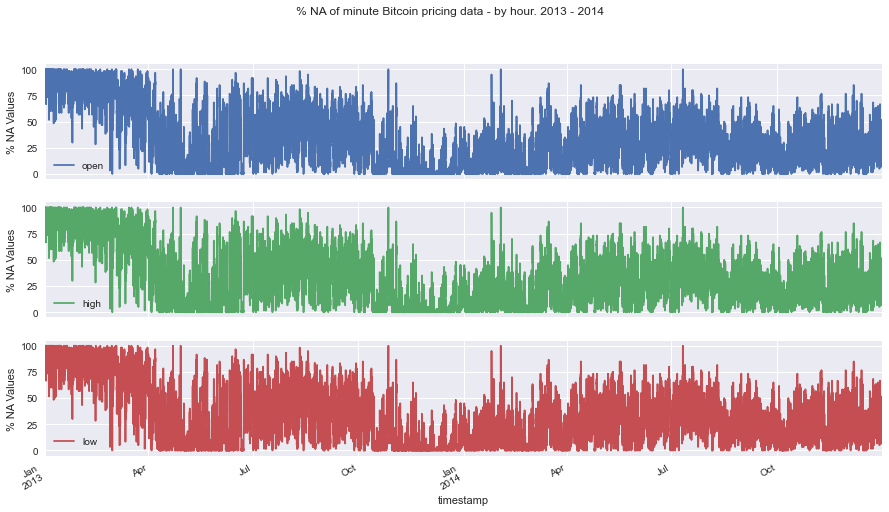

In [6]:
(
    data.isna()
    .groupby(pd.Grouper(freq="H"))
    .sum()
    .apply(
        lambda x: 100 * x / (60)
    )  # Calculate fraction of hours reading values are NA
    .query("index.dt.year == 2013 | index.dt.year == 2014")[["open", "high", "low"]]
    .plot(
        kind="line",
        subplots=True,
        title="% NA of minute Bitcoin pricing data - by hour. 2013 - 2014",
        ylabel="% NA Values",
    )
);

### Data Splitting and Filling

Let's get rid of the early data, and split into a test set here. We'll leak a bit of knowledge into our test set by splitting before the rebound in 2019, but the dataset after that point appears volatile and should be a relevant test set.

Early history (< 2017) is also before Bitcoin took off in the general public - have to see how/if the model can make effective use of this early data.

**We'll also carry forward to fill NA values for now.**

In [7]:
train_set_split_date = pd.to_datetime("2019/01/01")
start_date = pd.to_datetime("2014/01/01")

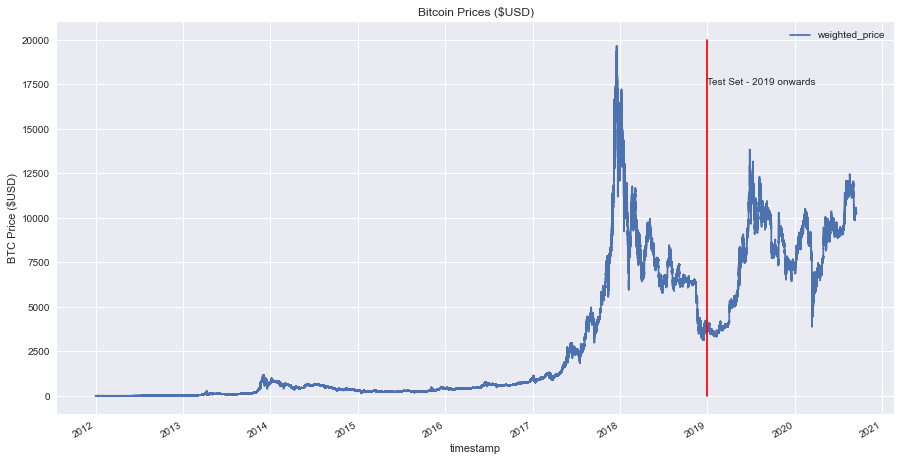

In [8]:
data.plot(
    kind="line",
    y="weighted_price",
    title="Bitcoin Prices ($USD)",
    ylabel="BTC Price ($USD)",
)
plt.plot([train_set_split_date, train_set_split_date], [0, 20000], "red")
plt.annotate("Test Set - 2019 onwards", (train_set_split_date, 17500));

In [9]:
data = data.loc[data.index > start_date].fillna(method="ffill")
train_df, test_df = (
    data.loc[data.index < train_set_split_date].dropna(),
    data.loc[data.index >= train_set_split_date].dropna(),
)

In [10]:
test_ratio = round(100 * test_df.shape[0] / (test_df.shape[0] + train_df.shape[0]), 1)
print(f"{test_ratio} % Test Split ")

25.5 % Test Split 


## Modelling

### Baselines

First lets get some baselines. How good could we do with bad forecasts? This can be captured by mean absolute scaled error (MASE [discussed here](https://robjhyndman.com/papers/forecompijf.pdf))  where we will scale by the errors made when just guessing the last known price. This means we evaluate MASE and if we are > 1, we are doing worse than guessing the last known price. Hopefully we can achieve values < 1, but as you step out to forecasting further time horizons (i.e hours or days ahead) this is harder to achieve.

This metric gives a better idea of how much skill we actually have in our forecast - if we look at the early time Bitcoin data, it would be pretty easy to guess the previous days price and be close to correct. In contrast, in the main Bitcoin bubble of 2017/2018 we would have some very bad predictions if we guessed the prior days price.

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin


def mase(y, y_pred):
    deltas = np.diff(y)
    d = np.abs(deltas[~np.isnan(deltas)]).sum() / y_pred.shape[0]
    errors = np.abs(y - y_pred)
    return errors.mean() / d


mase_scorer = make_scorer(mase, greater_is_better=False)


def plot_test_forecast(price_pred, price_actual, annotation):
    # Calculate the metric
    mase_predicted = round(mase(price_actual, price_pred), 2)

    # Show relative performance
    fig, ax = plt.subplots()
    price_pred.plot(ax=ax, label="Predicted")
    price_actual.plot(ax=ax, label="Actual")
    ax.annotate(annotation, xy=(0.75, 0.025), xycoords="figure fraction")
    ax.set_title(f"MASE: {mase_predicted}")
    ax.set_ylabel("Price ($USD)")
    ax.legend()

Lets pretend we were going to predict using a moving average and see how this stacks up on different volatility time periods. We'll look at the last year to get a baseline of MASE during more dramatic price movements. We'll also baseline against a narrower window with less volatility and see what MASE we can achieve.

In both cases, we'll use daily pricing for a simpler example.

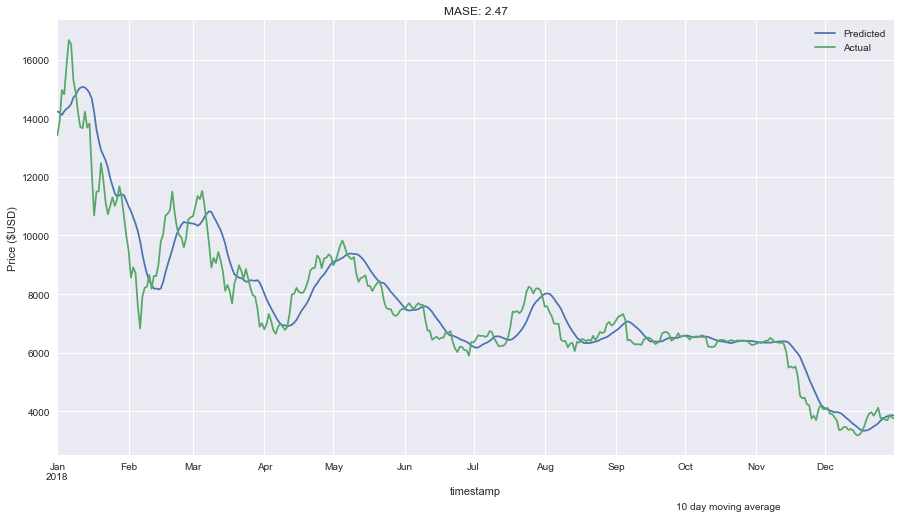

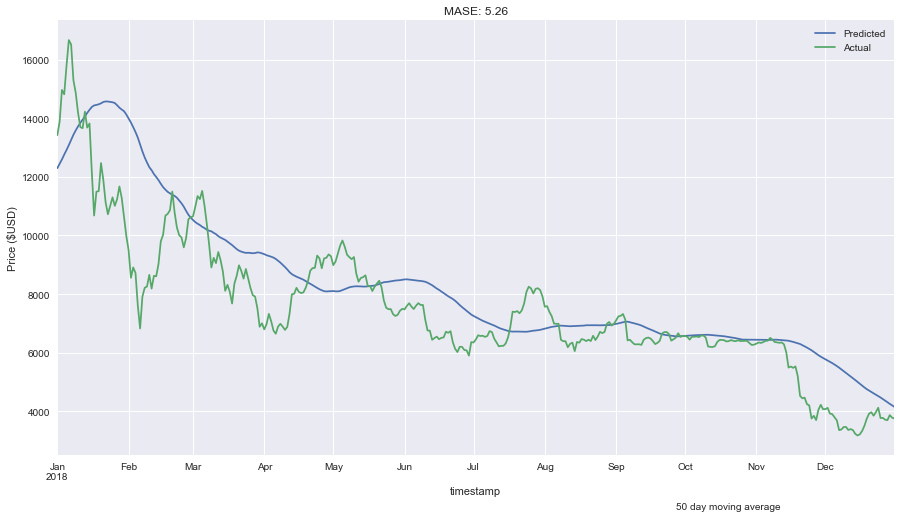

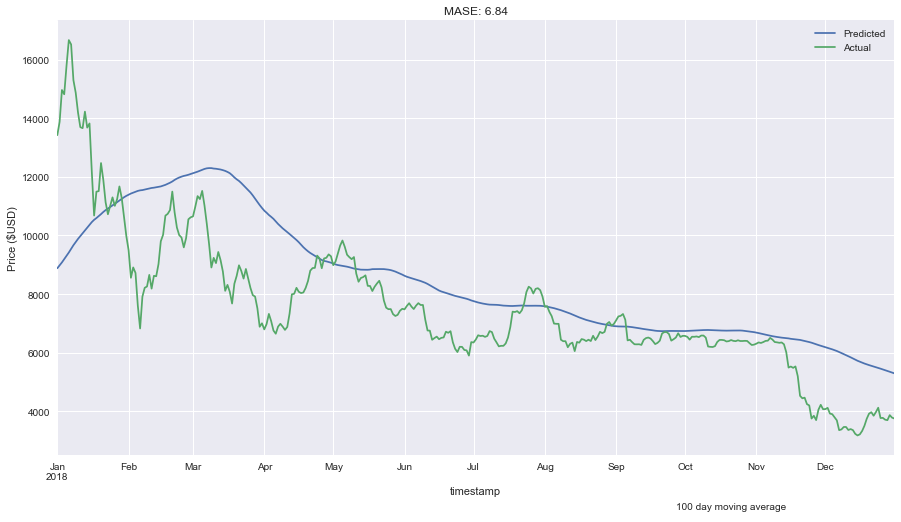

In [12]:
# Near end of dataset
num_steps = 365
sample_df = train_df.groupby(pd.Grouper(freq="D")).mean()

# Note - calculate rolling windows before filtering
for win in [10, 50, 100]:
    plot_test_forecast(
        sample_df["weighted_price"]
        .shift(1)
        .rolling(window=win, min_periods=0)
        .mean()
        .tail(num_steps),
        sample_df["weighted_price"].tail(num_steps),
        annotation=f"{win} day moving average",
    )

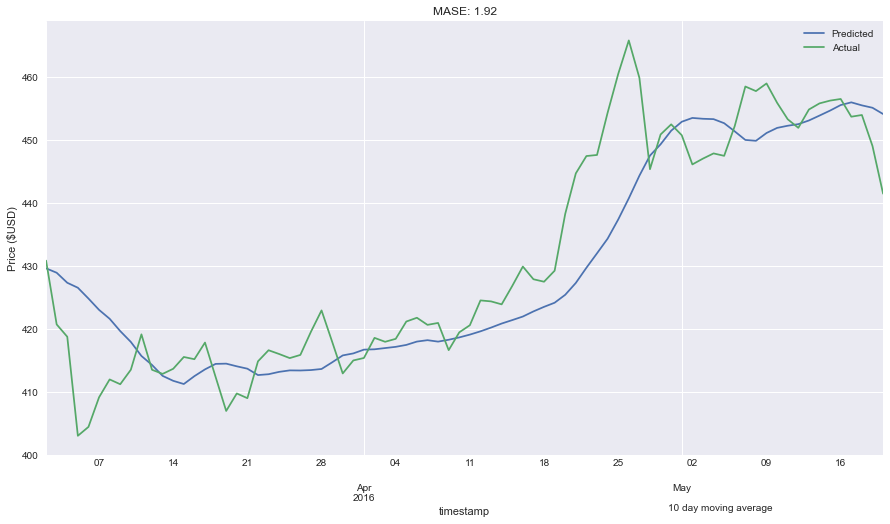

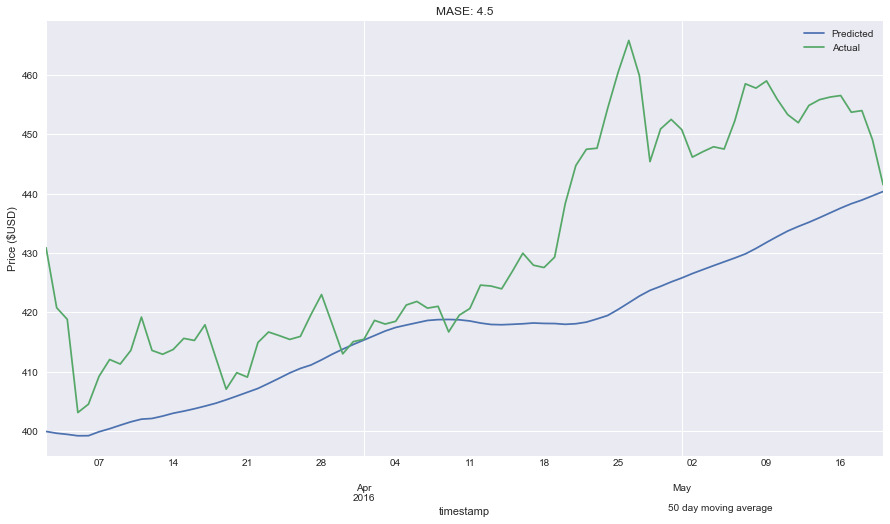

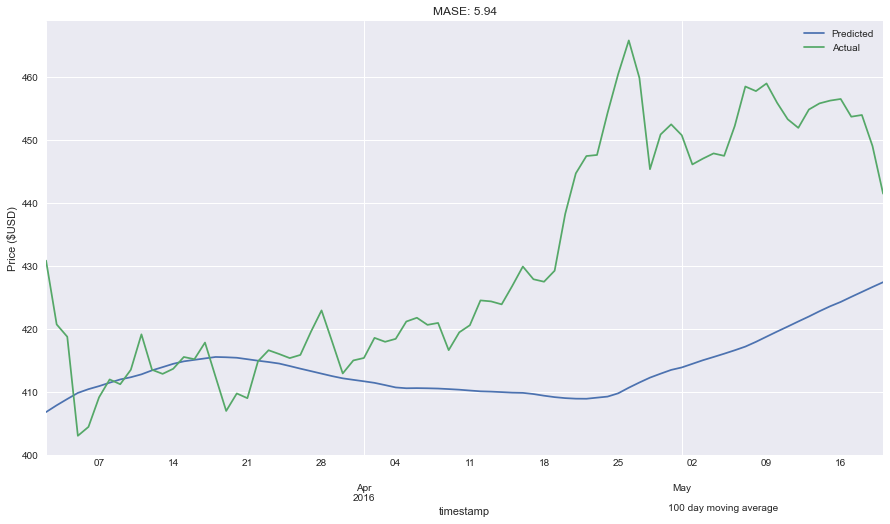

In [13]:
num_steps = 80
sample_df = train_df.groupby(pd.Grouper(freq="D")).mean()
start_date = "2016-03-01"

# Look at a smaller window in the middle with less volatility.
# Note - calculate rolling windows before filtering
for win in [10, 50, 100]:
    plot_test_forecast(
        sample_df["weighted_price"]
        .shift(1)
        .rolling(window=win, min_periods=0)
        .mean()[sample_df.index > start_date]
        .head(num_steps),
        sample_df.loc[sample_df.index > start_date, "weighted_price"].head(num_steps),
        annotation=f"{win} day moving average",
    )

Looks like aggregated to daily pricing, using simplistic moving averages calculated using previous pricing data, the best MASE we can achieve is ~ 1.9. This might change if we are trying to predict with less fidelity (i.e monthly pricing).

One more benchmark we can do - looking at different aggregation levels, how bad do we do if we guess the average price of the training data? Below we aggregate to hourly, daily, weekly and monthly average prices and try to predict on held out future data, using the mean training prices.

In [14]:
dummy_results = pd.DataFrame()
freqs = ["H", "D", "W", "M"]

for f in freqs:

    resample = train_df["weighted_price"].groupby(pd.Grouper(freq=f)).mean().dropna()

    res = cross_validate(
        DummyRegressor(),
        resample.shift(1),
        resample,
        cv=TimeSeriesSplit(n_splits=5),
        scoring=mase_scorer,
        return_train_score=True,
    )

    dummy_results[f"Frequency {f}"] = pd.DataFrame(res).mean()

dummy_results.rename(index={"test_score":"validation_score"})

,Frequency H,Frequency D,Frequency W,Frequency M
fit_time,0.001000,0.001000,0.001199,0.000600
score_time,0.000800,0.000000,0.000600,0.000600
validation_score,-175.997356,-31.484821,-11.627264,-5.767979
train_score,-98.468840,-19.144045,-6.930755,-2.945230


Ok, so no suprise here. Predicting the mean price over our training set ($E[Y|X]$) yields some bad results. Even on a monthly price, we are at a MASE of 2.95 (the negative is added by `sklearn` so we maximize this value).

Next we need to setup how we are going to validate our models. We can't just randomize and do K-fold validation as validation data that occurs in time before training data might leak information into our training set. This would mean we'd be subtly fitting any signals in the validation set that are meant to objectively test our model. So we want validation data to occur **after** training data. `sklearn` has this built in with `TimeSeriesSplit`. For a great discussion of the cross validation strategies in `sklearn` by default, see [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html).

Here's the basic Kfold Validation visual:

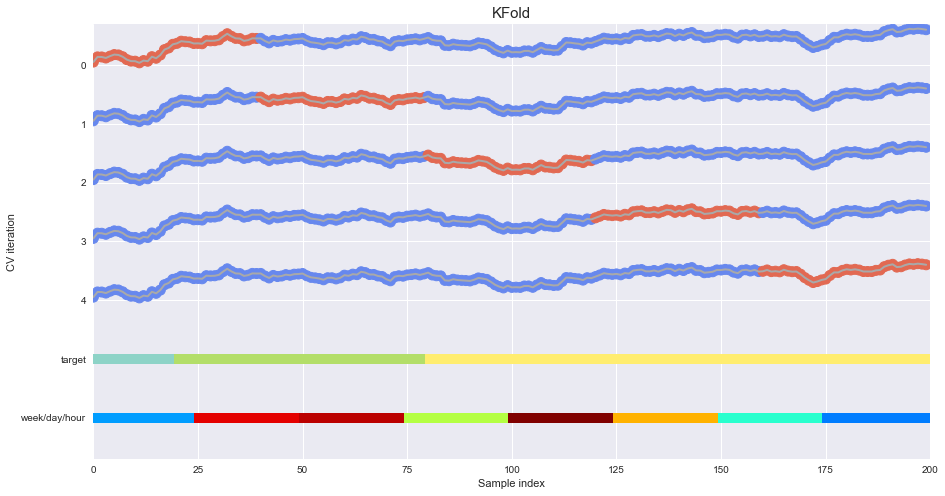

In [29]:
# CV Plotting code modified from:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

# Generate the class/group data
n_points = 200
X_example = np.random.randn(n_points, 1)

percentiles_classes = [.1, .3, .6]
y_example = np.hstack([[ii] * int(n_points * perc)
               for ii, perc in enumerate(percentiles_classes)])

# Evenly spaced groups repeated once
n_groups = 8
groups = np.hstack([[ii] * int(n_points/n_groups) for ii in range(int(n_groups))])

n_splits = 5

fig, ax = plt.subplots()
cv1 = KFold(n_splits)

plot_cv_indices(cv1, X_example, y_example, groups, ax, n_splits,group_name="week/day/hour");

And the `TimeSeriesSplit` style CV, notice how the validation set is always later than the training set:

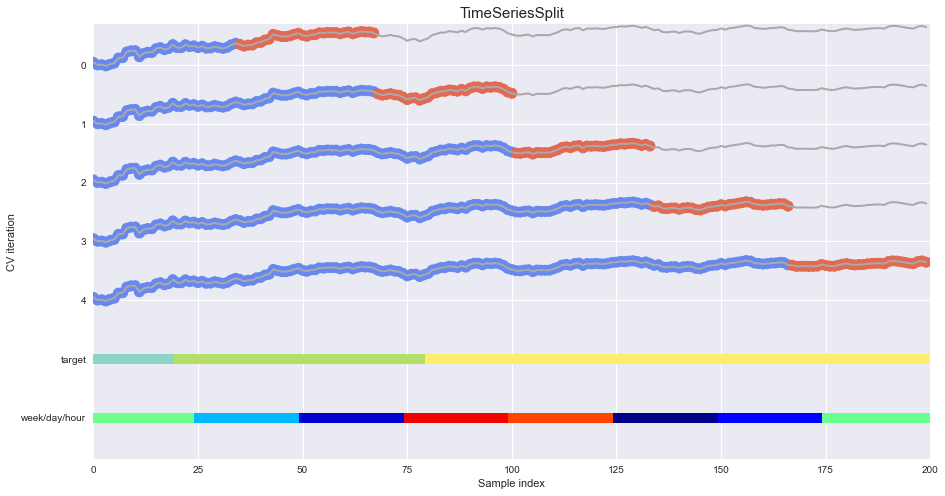

In [16]:
fig,ax=plt.subplots()
cv2 = TimeSeriesSplit(n_splits)
plot_cv_indices(cv2, X_example, y_example, groups, ax, n_splits,group_name="week/day/hour");

In the plots above the bottom row, "week/day/hour" shows how we want to maintain these groups when we do our splits. Concretely, we want to train on a certain set of days pricing, and validate on a completely separate set of days. 

The next concept that comes up is if we are calculating lagged terms such as moving averages, we want to ensure we have a gap between our validation data and our training set. At first this might not be so obvious, but if we look at a moving average with a decent window size we can see that our moving average is going to be carrying information from our training set into our validation set. 

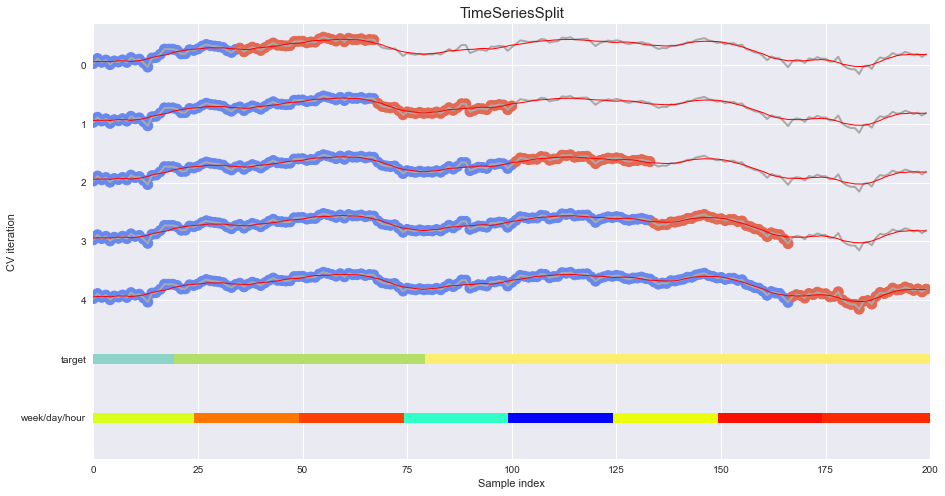

In [17]:
fig,ax=plt.subplots()
plot_cv_indices(cv2, X_example, y_example, groups, ax, n_splits,group_name="week/day/hour", moving_average=10);

Notice how the moving average in red has trends in it that are carrying from the training set (blue) into the validation set (salmon?)...not good!

To solve both of these problems, we use a splitter that will honour a grouping column (i.e days) and will also build a gap in between training set and validation set to prevent carrying trends into the validation set. Thanks to the wonders of the internet (and Kaggle making it easier to share good ideas) - we can use a splitter built for `sklearn` from [here](https://www.kaggle.com/marketneutral/purged-time-series-cv-xgboost-optuna).

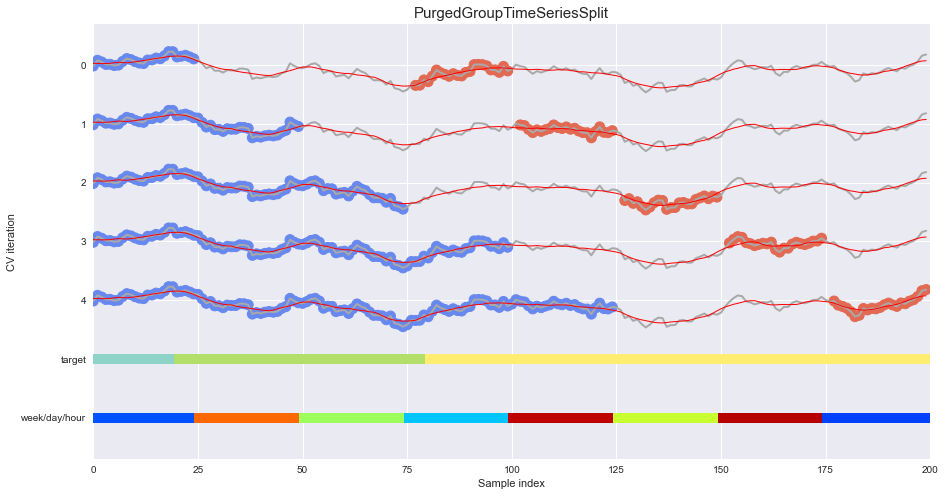

In [27]:
fig,ax=plt.subplots()
cv3 = PurgedGroupTimeSeriesSplit(n_splits, group_gap=2, max_train_group_size=30)
plot_cv_indices(cv3, X_example, y_example, groups, ax, n_splits,group_name="week/day/hour", moving_average=10);

Looks pretty good! All boundaries in our group column at the bottom are honored (i.e each day), and there is a gap between our train and validation sets. The gap width, and max training set size are parameters we need to double check depending on our fitting process. If we have a 100 day moving average being used we may want to have a larger gap than if we were using a 20 day moving average.

## Feature Engineering

Alright - with a solid CV strategy in place and our data split and mostly clean, we are ready to think about adding new features. This is typical of technical analysis of stocks - moving average convergence/divergence (MACD) and relative strength index (RSI) are two prominnent examples (read more [here](https://www.investopedia.com/terms/m/macd.asp#)). Put simply, the MACD is looking at exponential moving averages (more recent data is more important) and comparing how they change between different window sizes. RSI looks at current prices in relation to previous highs and lows. For both of these methods, if there is truly a signal to use MACD or RSI to predict pricing machine learning can find it! We can also evaluate numerous different ways of calculting these inputs and see if we can get an accurate model predicting on held out future data (validation set).

First we'll setup some transformers that allow us to quickly scale searching features, and hyperparameter settings for our algorithim in one step. First step is to build rolling windows of a specified size to evaluate when looking for a predictive features. Next we will augment with exponential moving averages and a few other manual feature calculations. Finally, we'll pass these into a automated time series feature engineering package, [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/introduction.html).

`tsfresh` will allow us to calculate a large number of features on each rolling window, and then select which ones are most informative. There are numerous features it can calculate with a range of simple (variance of an input over the window) to complex (auto-correlation statistics, Fourier transforms). 

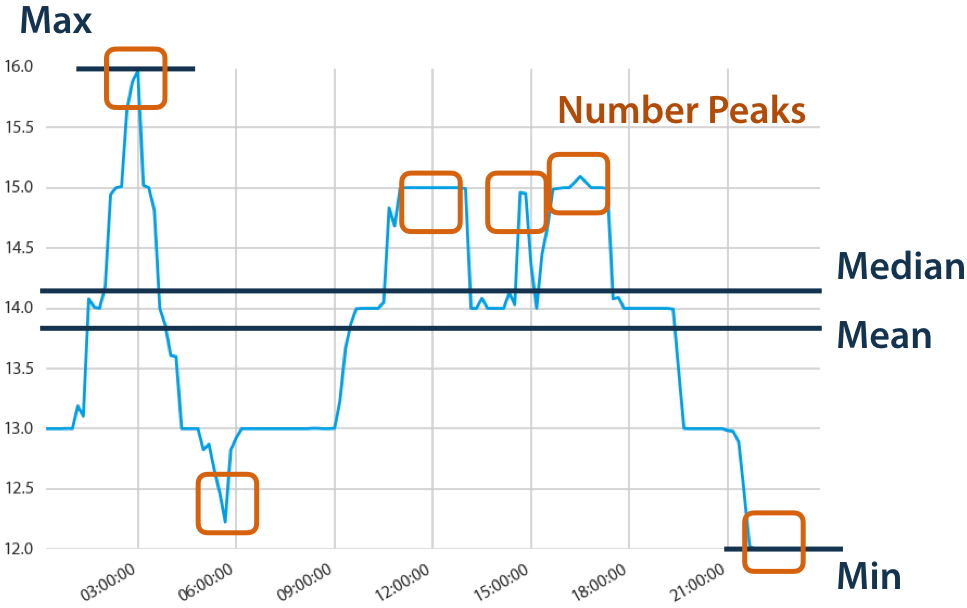

*`tsfresh` general features visual. From: https://tsfresh.readthedocs.io/en/latest/text/introduction.html*

Before we go any further, we'll aggregate to hourly data for prototyping on a smaller data set. We can revisit the minute data once we have the pipeline dialed. This takes us from ~2.9M rows down to ~42K rows. 

In [124]:
# Build out the correct aggregation from minute -> hour data.
# Using a clunky apply here to get the volume weighted price aggregated correctly
def hourly_agg(x):
    df = {}
    df["open"]=x.open[0]
    df["high"]=x['high'].max()
    df["low"]=x.low.min()
    df["close"]=x.close[-1]
    df["volume_btc"]=x.volume_btc.sum()
    df["volume_currency"]= x.volume_currency.sum()
    df["weighted_price"] = (x.volume_btc*x.weighted_price).sum()/x.volume_btc.sum()
    
    return pd.Series(df, index=['open','high','low','close','volume_btc','volume_currency','weighted_price'])

# train_df_hourly = train_df.resample('60MIN', closed='left', label='left').apply(hourly_agg)
train_df_hourly = train_df.groupby(pd.Grouper(freq="H")).apply(hourly_agg)

In [125]:
train_df_hourly

,open,high,low,close,volume_btc,volume_currency,weighted_price
timestamp,,,,,,,
2018-12-31 07:00:00,3785.94,3792.29,3781.28,3782.80,77.902072,2.948192e+05,3784.484265
2018-12-31 08:00:00,3782.90,3784.16,3768.85,3778.00,179.619560,6.781280e+05,3775.357276
2018-12-31 09:00:00,3781.94,3822.64,3775.13,3795.21,224.147996,8.496680e+05,3790.656386
2018-12-31 10:00:00,3796.29,3809.50,3790.10,3798.00,173.896436,6.602896e+05,3797.027889
2018-12-31 11:00:00,3794.90,3799.54,3706.00,3738.00,823.131780,3.078767e+06,3740.308731
2018-12-31 12:00:00,3738.70,3759.23,3725.43,3758.22,491.671423,1.837797e+06,3737.856673
2018-12-31 13:00:00,3757.49,3767.41,3742.00,3751.00,294.933967,1.107425e+06,3754.822958
2018-12-31 14:00:00,3751.00,3793.98,3747.69,3787.56,272.358862,1.025017e+06,3763.478475
2018-12-31 15:00:00,3787.56,3801.24,3734.97,3771.66,305.256893,1.148869e+06,3763.612078


In [52]:
from sklearn.base import BaseEstimator, TransformerMixin


class BuildRollingWindows(BaseEstimator, TransformerMixin):
    """
    Takes in a Pandas Dataframe, and creates a rolled version of it building multiple successive windows of data.
    Each window will contain data up to and including a final index. Shift target y ahead by one time step to honour temporal dependence.
    Wraps `tsfresh` `roll_time_series`, all arguments passed through
    """
    def __init__(self,
    column_id,
    column_sort=None,
    column_kind=None,
    rolling_direction=1,
    max_timeshift=None,
    min_timeshift=0,
    chunksize=None,
    n_jobs=4,
    show_warnings=False,
    disable_progressbar=False,
    distributor=None):
        
        self.column_id = column_id
        self.column_sort= column_sort
        self.column_kind=column_kind
        self.rolling_direction= rolling_direction
        self.max_timeshift=max_timeshift
        self.min_timeshift= min_timeshift
        self.chunksize= chunksize
        self.n_jobs=n_jobs
        self.show_warnings=show_warnings
        self.disable_progressbar= disable_progressbar
        self.distributor= distributor
    
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        
        return roll_time_series(
        X,
        self.column_id,
        self.column_sort,
        self.column_kind,
        self.rolling_direction,
        self.max_timeshift,
        self.min_timeshift,
        self.chunksize,
        self.n_jobs,
        self.show_warnings,
        self.disable_progressbar,
        self.distributor 
        )
    
    
class AddEma(BaseEstimator, TransformerMixin):
    """
    Takes in a time series Pandas dataframe, adds exponential moving averages for each column in input dataframe. 
    """
    def __init__(self, alpha=0.5):
        self.alpha = alpha
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        for c in X.columns:
            X[f"{c}_ema_{self.alpha}"] = X.loc[:,c].ewm(alpha=self.alpha).mean()
        
        return X
        
        



In [53]:
AddEma().fit_transform(train_df.head(100))#.plot(kind="line", subplots=True)

<ipython-input-52-126331887dbf>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_ema_{self.alpha}"] = X.loc[:,c].ewm(alpha=self.alpha).mean()


,open,high,low,close,volume_btc,volume_currency,weighted_price,open_ema_0.5,high_ema_0.5,low_ema_0.5,close_ema_0.5,volume_btc_ema_0.5,volume_currency_ema_0.5,weighted_price_ema_0.5
timestamp,,,,,,,,,,,,,,
2014-01-01 00:02:00,732.01,732.75,729.01,729.01,1.138530,830.438062,729.394976,732.010000,732.750000,729.010000,729.010000,1.138530,830.438062,729.394976
2014-01-01 00:03:00,730.24,732.76,730.24,732.76,0.121000,88.596624,732.203507,730.830000,732.756667,729.830000,731.510000,0.460177,335.877103,731.267330
2014-01-01 00:04:00,732.76,734.00,732.76,734.00,52.120000,38251.836202,733.918576,731.932857,733.467143,731.504286,732.932857,29.980076,22002.139445,732.782328
2014-01-01 00:05:00,733.70,734.00,730.51,734.00,2.710080,1984.290334,732.188752,732.875333,733.751333,730.974000,733.502000,15.436078,11325.953253,732.465754
2014-01-01 00:06:00,733.70,734.00,733.70,734.00,0.264000,193.766100,733.962500,733.300968,733.879677,732.380968,733.759032,7.605328,5580.308271,733.238268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-01 01:37:00,739.64,739.64,739.64,739.64,0.302903,224.039523,739.640000,739.691228,739.712217,739.682237,739.699282,6.380604,4721.453332,739.699921
2014-01-01 01:38:00,739.64,739.64,739.64,739.64,0.302903,224.039523,739.640000,739.665614,739.676108,739.661118,739.669641,3.341754,2472.746427,739.669960
2014-01-01 01:39:00,739.64,739.64,739.64,739.64,0.302903,224.039523,739.640000,739.652807,739.658054,739.650559,739.654820,1.822329,1348.392975,739.654980


## Testing Windows.....

In [23]:
train_df.shape

(2622966, 7)

In [25]:
train_df.groupby(pd.Grouper(freq="H")).mean().shape

(43824, 7)

In [20]:
windower = BuildRollingWindows(column_id='id', column_sort='timestamp',max_timeshift=30, min_timeshift=30, chunksize=100)

df_sample = windower.fit_transform(train_df.reset_index().assign(id=1).head(1000))
# df_sample.to_parquet(path="train_windowed.parquet.gzip", compression='gzip')

Rolling: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


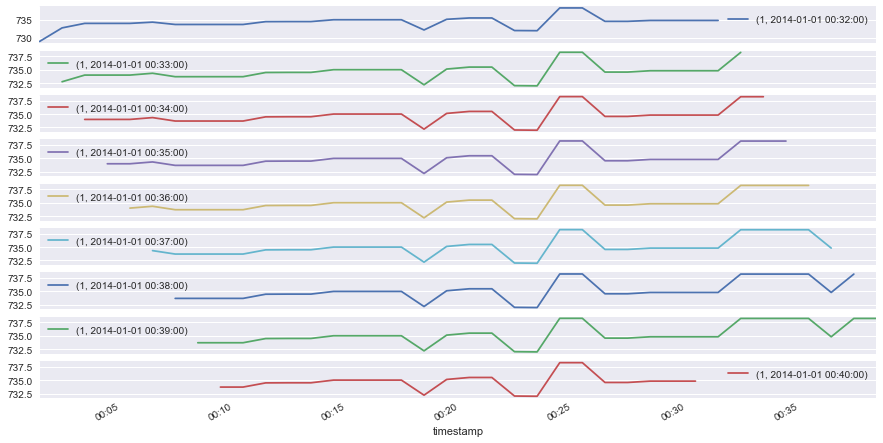

In [22]:
df_sample.head(270).pivot(index="timestamp", columns=["id"], values="close").reset_index().plot(
    kind="line",x="timestamp", by="id",subplots=True
);

In [108]:

x_sample_extracted = extract_features(df_sample, column_id="id", column_sort="timestamp")

Feature Extraction: 100%|██████████| 20/20 [17:41<00:00, 53.07s/it]  


In [118]:
y_sample = train_df.close.shift(-1)
x_sample = x_sample_extracted.set_index(x_sample_extracted.index.map(lambda x: x[1]), drop=True)
x_sample.index.name = "time_stamp"

x_sample.head()

,weighted_price__variance_larger_than_standard_deviation,weighted_price__has_duplicate_max,weighted_price__has_duplicate_min,weighted_price__has_duplicate,weighted_price__sum_values,weighted_price__abs_energy,weighted_price__mean_abs_change,weighted_price__mean_change,weighted_price__mean_second_derivative_central,weighted_price__median,...,volume_currency__fourier_entropy__bins_2,volume_currency__fourier_entropy__bins_3,volume_currency__fourier_entropy__bins_5,volume_currency__fourier_entropy__bins_10,volume_currency__fourier_entropy__bins_100,volume_currency__permutation_entropy__dimension_3__tau_1,volume_currency__permutation_entropy__dimension_4__tau_1,volume_currency__permutation_entropy__dimension_5__tau_1,volume_currency__permutation_entropy__dimension_6__tau_1,volume_currency__permutation_entropy__dimension_7__tau_1
time_stamp,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:07:00,1.0,0.0,0.0,0.0,4395.994919,3.220812e+06,1.678256,0.986326,-0.305553,733.061042,...,0.693147,1.039721,1.386294,1.386294,1.386294,1.039721,1.098612,0.693147,-0.0,NaN
2014-01-01 00:08:00,1.0,0.0,0.0,0.0,4397.450314,3.222938e+06,1.811798,-0.270627,-0.648913,733.061042,...,0.562335,0.562335,1.039721,1.039721,1.386294,1.386294,1.098612,0.693147,-0.0,NaN
2014-01-01 00:09:00,1.0,0.0,1.0,1.0,4396.097177,3.220958e+06,1.468784,-0.613641,0.216228,733.053664,...,0.693147,0.693147,0.693147,1.039721,1.386294,1.039721,1.098612,0.693147,-0.0,NaN
2014-01-01 00:10:00,1.0,0.0,1.0,1.0,4395.878600,3.220637e+06,1.692745,0.302250,0.134485,732.944376,...,0.562335,1.039721,1.386294,1.386294,1.386294,1.039721,1.098612,0.693147,-0.0,NaN
2014-01-01 00:11:00,1.0,0.0,1.0,1.0,4397.389881,3.222852e+06,1.338002,-0.052493,-0.045509,733.700016,...,0.693147,0.693147,1.039721,1.386294,1.386294,1.039721,1.098612,0.693147,-0.0,NaN


In [121]:
# Align on timestamp
y_sample = y_sample[y_sample.index.isin(x_sample.index)]
x_sample = x_sample[x_sample.index.isin(y_sample.index)]

In [122]:
x_sample.shape

(9995, 5453)

In [123]:
y_sample.shape

(9995,)

In [124]:
# Get rid of NA features.....then select!
x_sample.dropna(axis=1, inplace=True)
x_sample = select_features(x_sample, y_sample)

array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>], dtype=object)

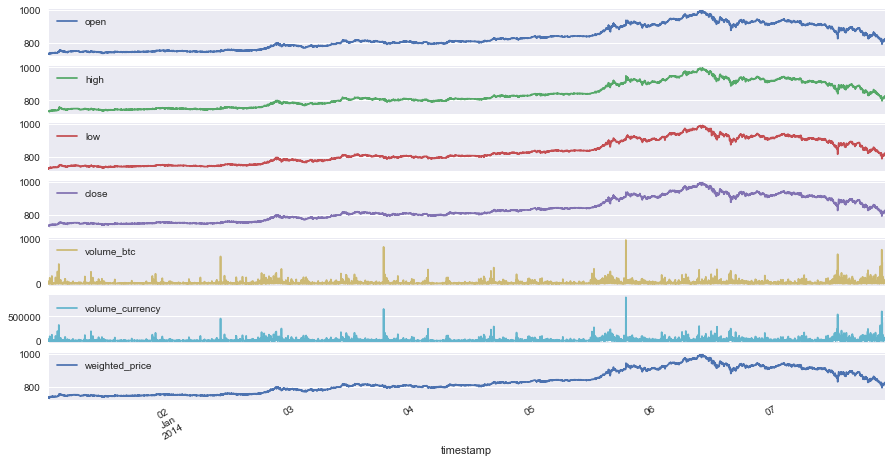

In [128]:
train_df.reset_index().head(10000).plot(x='timestamp', subplots=True)

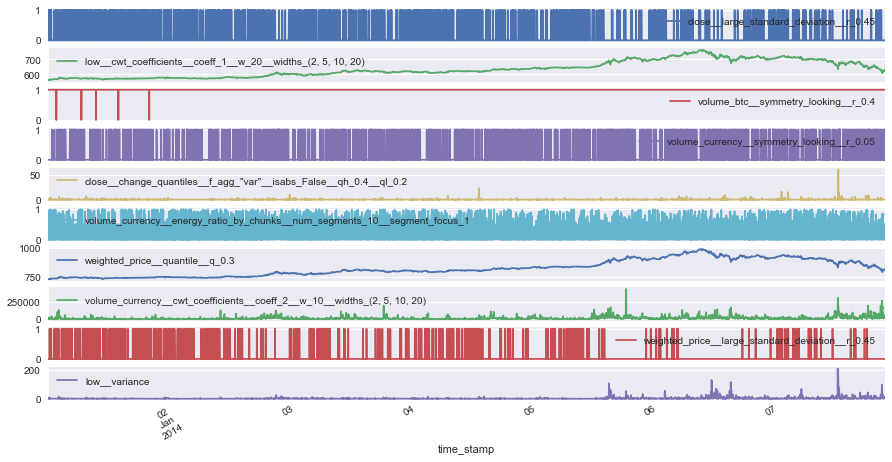

In [131]:
# Plot 10 random features over time.....
random_pick = np.random.randint(0,len(x_sample.columns),size=10)
x_sample.iloc[:,random_pick].plot(
    kind="line",subplots=True
);

In [59]:
extract_relevant_features(df_ts, y, column_id='id', column_sort='time')

ValueError: A value for column_id needs to be supplied

In [31]:
# Download dataset
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures
download_robot_execution_failures()

pipeline = Pipeline([('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='time')),
            ('classifier', RandomForestClassifier())])

df_ts, y = load_robot_execution_failures()
X = pd.DataFrame(index=y.index)

pipeline.set_params(augmenter__timeseries_container=df_ts)
pipeline.fit(X, y)

Feature Extraction: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
C:\Users\Drumm\miniconda3\envs\bitcoin\lib\site-packages\tsfresh\utilities\dataframe_functions.py:171: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


Pipeline(steps=[('augmenter',
                 RelevantFeatureAugmenter(column_id='id', column_sort='time',
                                          timeseries_container=      id  time  F_x  F_y  F_z  T_x  T_y  T_z
0      1     0   -1   -1   63   -3   -1    0
1      1     1    0    0   62   -3   -1    0
2      1     2   -1   -1   61   -3    0    0
3      1     3   -1   -1   63   -2   -1    0
4      1     4   -1   -1   63   -3   -1    0
...   ..   ...  ...  ...  ...  ...  ...  ...
1315  88    10  -10    2   39  -21  -24    5
1316  88    11  -11    2   38  -24  -22    6
1317  88    12  -12    3   23  -24  -24    5
1318  88    13  -13    4   26  -29  -27    5
1319  88    14  -13    2   15  -25  -25    6

[1320 rows x 8 columns])),
                ('classifier', RandomForestClassifier())])

In [51]:
augmenter = pipeline.named_steps["augmenter"]
imps = pd.DataFrame(
    data=pipeline.named_steps["classifier"].feature_importances_,
    index=augmenter.feature_selector.relevant_features,
    columns=["importance"],
)
imps.sort_values("importance", ascending=False).head(20)

,importance
T_y__standard_deviation,0.049878
F_x__variance,0.040090
"F_z__fft_aggregated__aggtype_""centroid""",0.038532
F_y__abs_energy,0.032670
F_x__abs_energy,0.030688
F_x__range_count__max_1__min_-1,0.029839
T_x__standard_deviation,0.027474
F_z__minimum,0.026170
"F_x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""",0.025881
"T_x__fft_coefficient__attr_""abs""__coeff_1",0.025853


In [57]:
train_df.head()

,open,high,low,close,volume_btc,volume_currency,weighted_price
timestamp,,,,,,,
2014-01-01 00:02:00,732.01,732.75,729.01,729.01,1.13853,830.438062,729.394976
2014-01-01 00:03:00,730.24,732.76,730.24,732.76,0.12100,88.596624,732.203507
2014-01-01 00:04:00,732.76,734.00,732.76,734.00,52.12000,38251.836202,733.918576
2014-01-01 00:05:00,733.70,734.00,730.51,734.00,2.71008,1984.290334,732.188752
2014-01-01 00:06:00,733.70,734.00,733.70,734.00,0.26400,193.766100,733.962500


In [73]:
from tsfresh import extract_relevant_features
features_filtered_direct = extract_relevant_features(df_ts, y,
                                                     column_id='id', column_sort='time')

Feature Extraction: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


In [76]:
df_ts.head(30)

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
5,1,5,-1,-1,63,-3,-1,0
6,1,6,-1,-1,63,-3,0,0
7,1,7,-1,-1,63,-3,-1,0
8,1,8,-1,-1,63,-3,-1,0
9,1,9,-1,-1,61,-3,0,0


In [75]:
features_filtered_direct

,F_x__value_count__value_-1,F_x__abs_energy,F_x__range_count__max_1__min_-1,F_y__abs_energy,T_y__variance,T_y__standard_deviation,"F_x__fft_coefficient__attr_""abs""__coeff_1","T_y__fft_coefficient__attr_""abs""__coeff_1",T_y__abs_energy,F_z__standard_deviation,...,"T_x__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0","F_z__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8",T_x__quantile__q_0.1,F_y__has_duplicate_max,"F_y__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)","F_y__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)",T_y__quantile__q_0.1,F_z__time_reversal_asymmetry_statistic__lag_1,F_x__quantile__q_0.2,F_y__quantile__q_0.7
1,14.0,14.0,15.0,13.0,0.222222,0.471405,1.000000,1.165352,10.0,1.203698,...,0.000000,0.0,-3.0,1.0,-0.751682,-0.310265,-1.0,-5.960000e+02,-1.0,-1.0
2,7.0,25.0,13.0,76.0,4.222222,2.054805,0.624118,6.020261,90.0,4.333846,...,0.000000,1.0,-9.2,1.0,0.057818,-0.202951,-3.6,-6.803846e+02,-1.0,-1.0
3,11.0,12.0,14.0,40.0,3.128889,1.768867,2.203858,8.235442,103.0,4.616877,...,0.000000,3.0,-6.6,0.0,0.912474,0.539121,-4.0,-6.170000e+02,-1.0,0.0
4,5.0,16.0,10.0,60.0,7.128889,2.669998,0.844394,12.067855,124.0,3.833188,...,0.000000,0.0,-9.0,0.0,-0.609735,-2.641390,-4.6,3.426308e+03,-1.0,1.0
5,9.0,17.0,13.0,46.0,4.160000,2.039608,2.730599,6.445330,180.0,4.841487,...,0.000000,0.0,-9.6,0.0,0.072771,0.591927,-5.0,-2.609000e+03,-1.0,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.0,96833.0,0.0,42780.0,1563.528889,39.541483,359.248162,309.190088,171261.0,291.988082,...,64.000000,46.0,203.2,0.0,71.641254,38.559593,36.4,-7.700628e+07,-105.0,66.8
85,0.0,1683.0,0.0,1523.0,14.755556,3.841296,36.770027,26.631007,503.0,14.501494,...,4.666667,4.5,-41.6,0.0,16.349699,14.429645,1.0,-1.050785e+04,5.8,10.6
86,0.0,83497.0,0.0,21064.0,2788.595556,52.807154,312.044052,429.697740,118013.0,121.420189,...,0.250000,7.0,-84.8,0.0,71.095480,60.760842,19.6,-5.544922e+06,30.4,38.4
87,0.0,1405437.0,0.0,308658.0,6415.715556,80.098162,481.046930,683.196535,2430295.0,204.966621,...,0.000000,90.5,-139.2,0.0,173.699573,109.029954,272.6,-9.881845e+07,246.8,154.8


In [74]:
features_filtered_direct.shape

(88, 671)

In [39]:
features_filtered_direct

,F_x__value_count__value_-1,F_x__abs_energy,F_x__range_count__max_1__min_-1,F_y__abs_energy,T_y__variance,T_y__standard_deviation,"F_x__fft_coefficient__attr_""abs""__coeff_1","T_y__fft_coefficient__attr_""abs""__coeff_1",T_y__abs_energy,F_z__standard_deviation,...,"T_x__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0","F_z__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8",T_x__quantile__q_0.1,F_y__has_duplicate_max,"F_y__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)","F_y__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)",T_y__quantile__q_0.1,F_z__time_reversal_asymmetry_statistic__lag_1,F_x__quantile__q_0.2,F_y__quantile__q_0.7
1,14.0,14.0,15.0,13.0,0.222222,0.471405,1.000000,1.165352,10.0,1.203698,...,0.000000,0.0,-3.0,1.0,-0.751682,-0.310265,-1.0,-5.960000e+02,-1.0,-1.0
2,7.0,25.0,13.0,76.0,4.222222,2.054805,0.624118,6.020261,90.0,4.333846,...,0.000000,1.0,-9.2,1.0,0.057818,-0.202951,-3.6,-6.803846e+02,-1.0,-1.0
3,11.0,12.0,14.0,40.0,3.128889,1.768867,2.203858,8.235442,103.0,4.616877,...,0.000000,3.0,-6.6,0.0,0.912474,0.539121,-4.0,-6.170000e+02,-1.0,0.0
4,5.0,16.0,10.0,60.0,7.128889,2.669998,0.844394,12.067855,124.0,3.833188,...,0.000000,0.0,-9.0,0.0,-0.609735,-2.641390,-4.6,3.426308e+03,-1.0,1.0
5,9.0,17.0,13.0,46.0,4.160000,2.039608,2.730599,6.445330,180.0,4.841487,...,0.000000,0.0,-9.6,0.0,0.072771,0.591927,-5.0,-2.609000e+03,-1.0,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.0,96833.0,0.0,42780.0,1563.528889,39.541483,359.248162,309.190088,171261.0,291.988082,...,64.000000,46.0,203.2,0.0,71.641254,38.559593,36.4,-7.700628e+07,-105.0,66.8
85,0.0,1683.0,0.0,1523.0,14.755556,3.841296,36.770027,26.631007,503.0,14.501494,...,4.666667,4.5,-41.6,0.0,16.349699,14.429645,1.0,-1.050785e+04,5.8,10.6
86,0.0,83497.0,0.0,21064.0,2788.595556,52.807154,312.044052,429.697740,118013.0,121.420189,...,0.250000,7.0,-84.8,0.0,71.095480,60.760842,19.6,-5.544922e+06,30.4,38.4
87,0.0,1405437.0,0.0,308658.0,6415.715556,80.098162,481.046930,683.196535,2430295.0,204.966621,...,0.000000,90.5,-139.2,0.0,173.699573,109.029954,272.6,-9.881845e+07,246.8,154.8


In [53]:
df_ts.shape

(1320, 8)

In [54]:
X.shape

(88, 0)

In [55]:
df_ts

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5
